# Using Weave with VLMs

This guide showcases how to build, track and evaluate a computer vision pipeline using VLMs (Vision Language models) to perform OCR (optical character recognition) for NER (named entity recognition) applications.

## Introduction

In this guide, we will use Weave by W&B to track and evaluate this pipeline. Weave is designed to help you iterate on your GenAI applications rapidly with minimal lift. Weave has native integration that allow you to build with the latest frameworks from OpenAI, Crew, AWS, Google etc.

This example uses OpenAI's GPT-4.1's vision capabilities to extract named entities from handwritten notes.

This notebook covers the following sections:
1. Tracking different versions of our system prompts
2. Get an Image dataset from Weave
2. Create a Named Entity Recognition (NER) pipeline
3. Setup Scorers to evaluate our pipeline
  - Programmatic Scorer to ensure all expected entities are extracted
  - LLM-as-a-judge Scorer that evaluates the results comprehensively  
4. Running an evaluation against our dataset of handwritten notes

In [1]:
#install dependencies
!pip install openai weave -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.8/501.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.6 MB/s eta 0:00:00


###  Environment Setup
We begin by installing and importing the required libraries. This sets up our environment to use OpenAI's APIs and W&B Weave for tracking.

In [2]:
from openai import OpenAI
import weave
import os
import base64
from google.colab import userdata
from pathlib import Path
import json
from io import BytesIO
from PIL import Image

  if event.key is 'enter':



In [4]:
#Get API Keys
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY') #please set the keys as collab environment secrets from the menu on the left
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')

#set project name
PROJECT = "vlm-handwritten-ner" #Add your uniwue project name

# Init Weave
weave.init(PROJECT)

Logged in as Weights & Biases user: anushrav-vatsa.
View Weave data at https://wandb.ai/wandb-smle/vlm-handwritten-ner/weave


## 1. Prompt Engineering
Prompting is a critical step in guiding the model to extract accurate entities. We'll start with a basic version and gradually refine it to improve results.

## Let's create and track some prompts for our project

We start with a basic prompt that gives the model the instructions on what to extract from our image data and how to format it.

In [5]:
# Create your prompt object with Weave
prompt="""
Extract all readable text from this image. Format the extracted entities as a valid JSON.
Do not return any extra text, just the JSON. Do not include ```json```
Use the following format:
{"Patient Name": "James James","Date": "4/22/2025","Patient ID": "ZZZZZZZ123","Group Number": "3452542525"}
"""
system_prompt = weave.StringPrompt(prompt)
# Publish your prompt to weave
weave.publish(system_prompt, name="NER-prompt")

📦 Published to https://wandb.ai/wandb-smle/vlm-handwritten-ner/weave/objects/NER-prompt/versions/xhL7TJYJR8mHFsKYVPR3Oejgpj9gcuHZqcVadW8hE2o


ObjectRef(entity='wandb-smle', project='vlm-handwritten-ner', name='NER-prompt', _digest='xhL7TJYJR8mHFsKYVPR3Oejgpj9gcuHZqcVadW8hE2o', _extra=())

Next, let's iterate on this prompt by adding some more instructions and validations rules to help reduce errors on our output.

In [6]:
better_prompt="""
You are a precision OCR assistant. Given an image of patient information, extract exactly these fields into a single JSON object—and nothing else:

- Patient Name
- Date (MM/DD/YYYY)
- Patient ID
- Group Number

Validation rules:
1. Date must match MM/DD/YY; if not, set Date to "".
2. Patient ID must be alphanumeric; if unreadable, set to "".
3. Always zero-pad months and days (e.g. "04/07/25").
4. Omit any markup, commentary, or code fences.
5. Return strictly valid JSON with only those four keys.

Do not return any extra text, just the JSON. Do not include ```json```
Example output:
{"Patient Name":"James James","Date":"04/22/25","Patient ID":"ZZZZZZZ123","Group Number":"3452542525"}
"""
# Editing the prompt
system_prompt = weave.StringPrompt(better_prompt)
# Publish the new edits
weave.publish(system_prompt, name="NER-prompt")

📦 Published to https://wandb.ai/wandb-smle/vlm-handwritten-ner/weave/objects/NER-prompt/versions/ef7Cd3vGxEd4OGSDgpwi8t0BvY99JphusigXrKlXYD4


ObjectRef(entity='wandb-smle', project='vlm-handwritten-ner', name='NER-prompt', _digest='ef7Cd3vGxEd4OGSDgpwi8t0BvY99JphusigXrKlXYD4', _extra=())

## 2. Get Dataset
We'll load a sample dataset of handwritten notes from an existing Weave project. These notes will serve as input for our OCR pipeline.


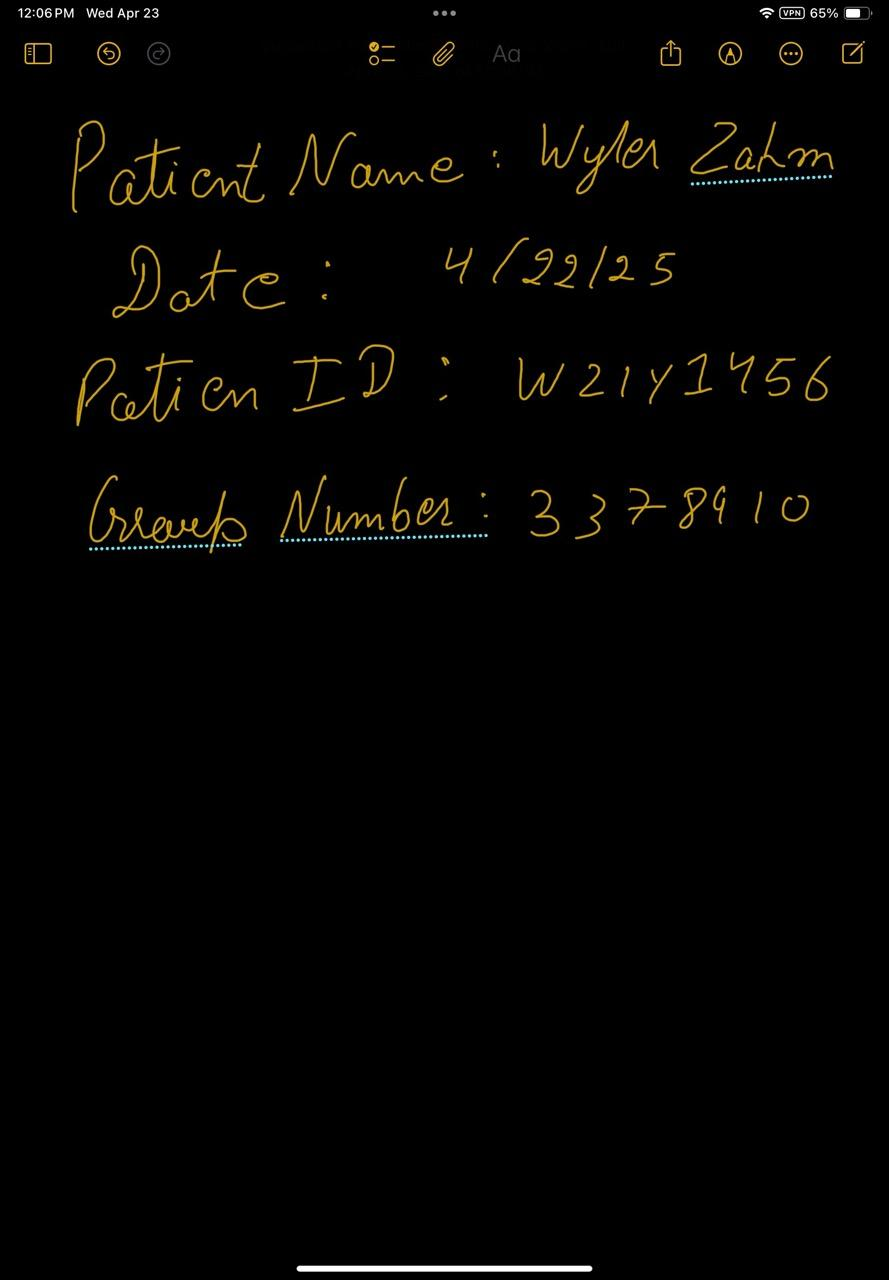

In [7]:
# Retrieve the dataset
dataset = weave.ref("weave:///wandb-smle/vlm-handwritten-ner/object/NER-eval-dataset:BVdFx1e3XwdftsxlCEdUHCac5pWhL8jVGnUFSvIHkTI").get()

# Access a specific example
example_image = dataset.rows[0]['image']
example_image

# 3. Let's build our Named Entity Recognition Pipeline

Our pipeline consists of two functions:
1. `encode_image` that takes a PIL image from our datasets and returns a base64 ended string for the image that we can pass to our VLM
2. `extract_named_entities_from_image` that takes our image and system prompt to return the extracted results

In [8]:
# Helper: Encode image to base64
def encode_image(pil_image: Image.Image, format: str = "JPEG") -> str:
    """Convert a PIL image to a base64 string."""
    buffered = BytesIO()
    pil_image.save(buffered, format=format)
    encoded_string = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return encoded_string

# Traceable function using GPT-4-Vision
def extract_named_entities_from_image(image) -> dict:
    base64_image = encode_image(image)

    #init LLM Client
    client = OpenAI()

    #Setup the instruction prompt
    #You can optionally use a prompt stored in Weave withweave.ref("weave:///wandb-smle/vlm-handwritten-ner/object/NER-prompt:FmCv4xS3RFU21wmNHsIYUFal3cxjtAkegz2ylM25iB8").get().content.strip()
    prompt = better_prompt

    response = client.responses.create(
    model="gpt-4.1",

    input=[
        {
            "role": "user",
            "content": [
                { "type": "input_text", "text":prompt},
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image}",
                },
            ],
        }
    ],
    )

    return response.output_text

Now, let's create an entry function that allows us to pass our image data to our NER pipeline and return correctly formatted JSON with the results.

We introduce [`@weave.op()`](https://weave-docs.wandb.ai/tutorial-tracing_2) decorator where to automatically grab the entire trace of our execution and make it available in our W&B UI.

Once you execute this pipeline you can view the traces from each execution in your **Weave UI**

In [9]:
#NER Function for evaluations
@weave.op()
def named_entity_recognation(image, id):
    result ={}
    try:
        # 1) call the vision op, get back a JSON string
        output_text = extract_named_entities_from_image(image)

        # 2) parse JSON exactly once
        result = json.loads(output_text)

        print(f"Processed: {str(id)}")
    except Exception as e:
        print(f"Failed to process {str(id)}: {e}")
    return result

Finally, with our pipeline ready, let's execute this pipeline over the dataset we grabbed earlier and view the results.

This cell loops over our dataset and stores the results in a local file `processing_results.json`. The results are also avaialble in the your Weave UI.

In [10]:
# Output results
results = []

#loop over all images in the dataset
for row in dataset.rows:
      result = named_entity_recognation(row['image'], str(row['id']))
      result["image_id"]=str(row['id'])
      results.append(result)

#Save all results to a JSON file
output_file = "processing_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {output_file}")

🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-4129-70f1-bea1-1063b9e82340
Processed: IMG_0046 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-4e55-72b2-9b41-b0d7b066c3b2
Processed: IMG_0047 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-561d-7220-89ab-742a9c3b0243
Processed: IMG_0044 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-5f9e-7402-bb8e-324e3181d922
Processed: IMG_0054 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-6d69-77f0-a3b9-c2c471981a5d
Processed: IMG_0050 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-76a9-7da2-81dc-38247fa45ae7
Processed: IMG_0045 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-7e9f-7710-8912-455c23312f6f
Processed: IMG_0051 Large.jpeg
🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-86d4-7712-b4fe-084bf7491740
Processed: IMG_0052 Large.jpeg


Here's the view you should see by following the trace results from this execution in your W&B Weave UI:

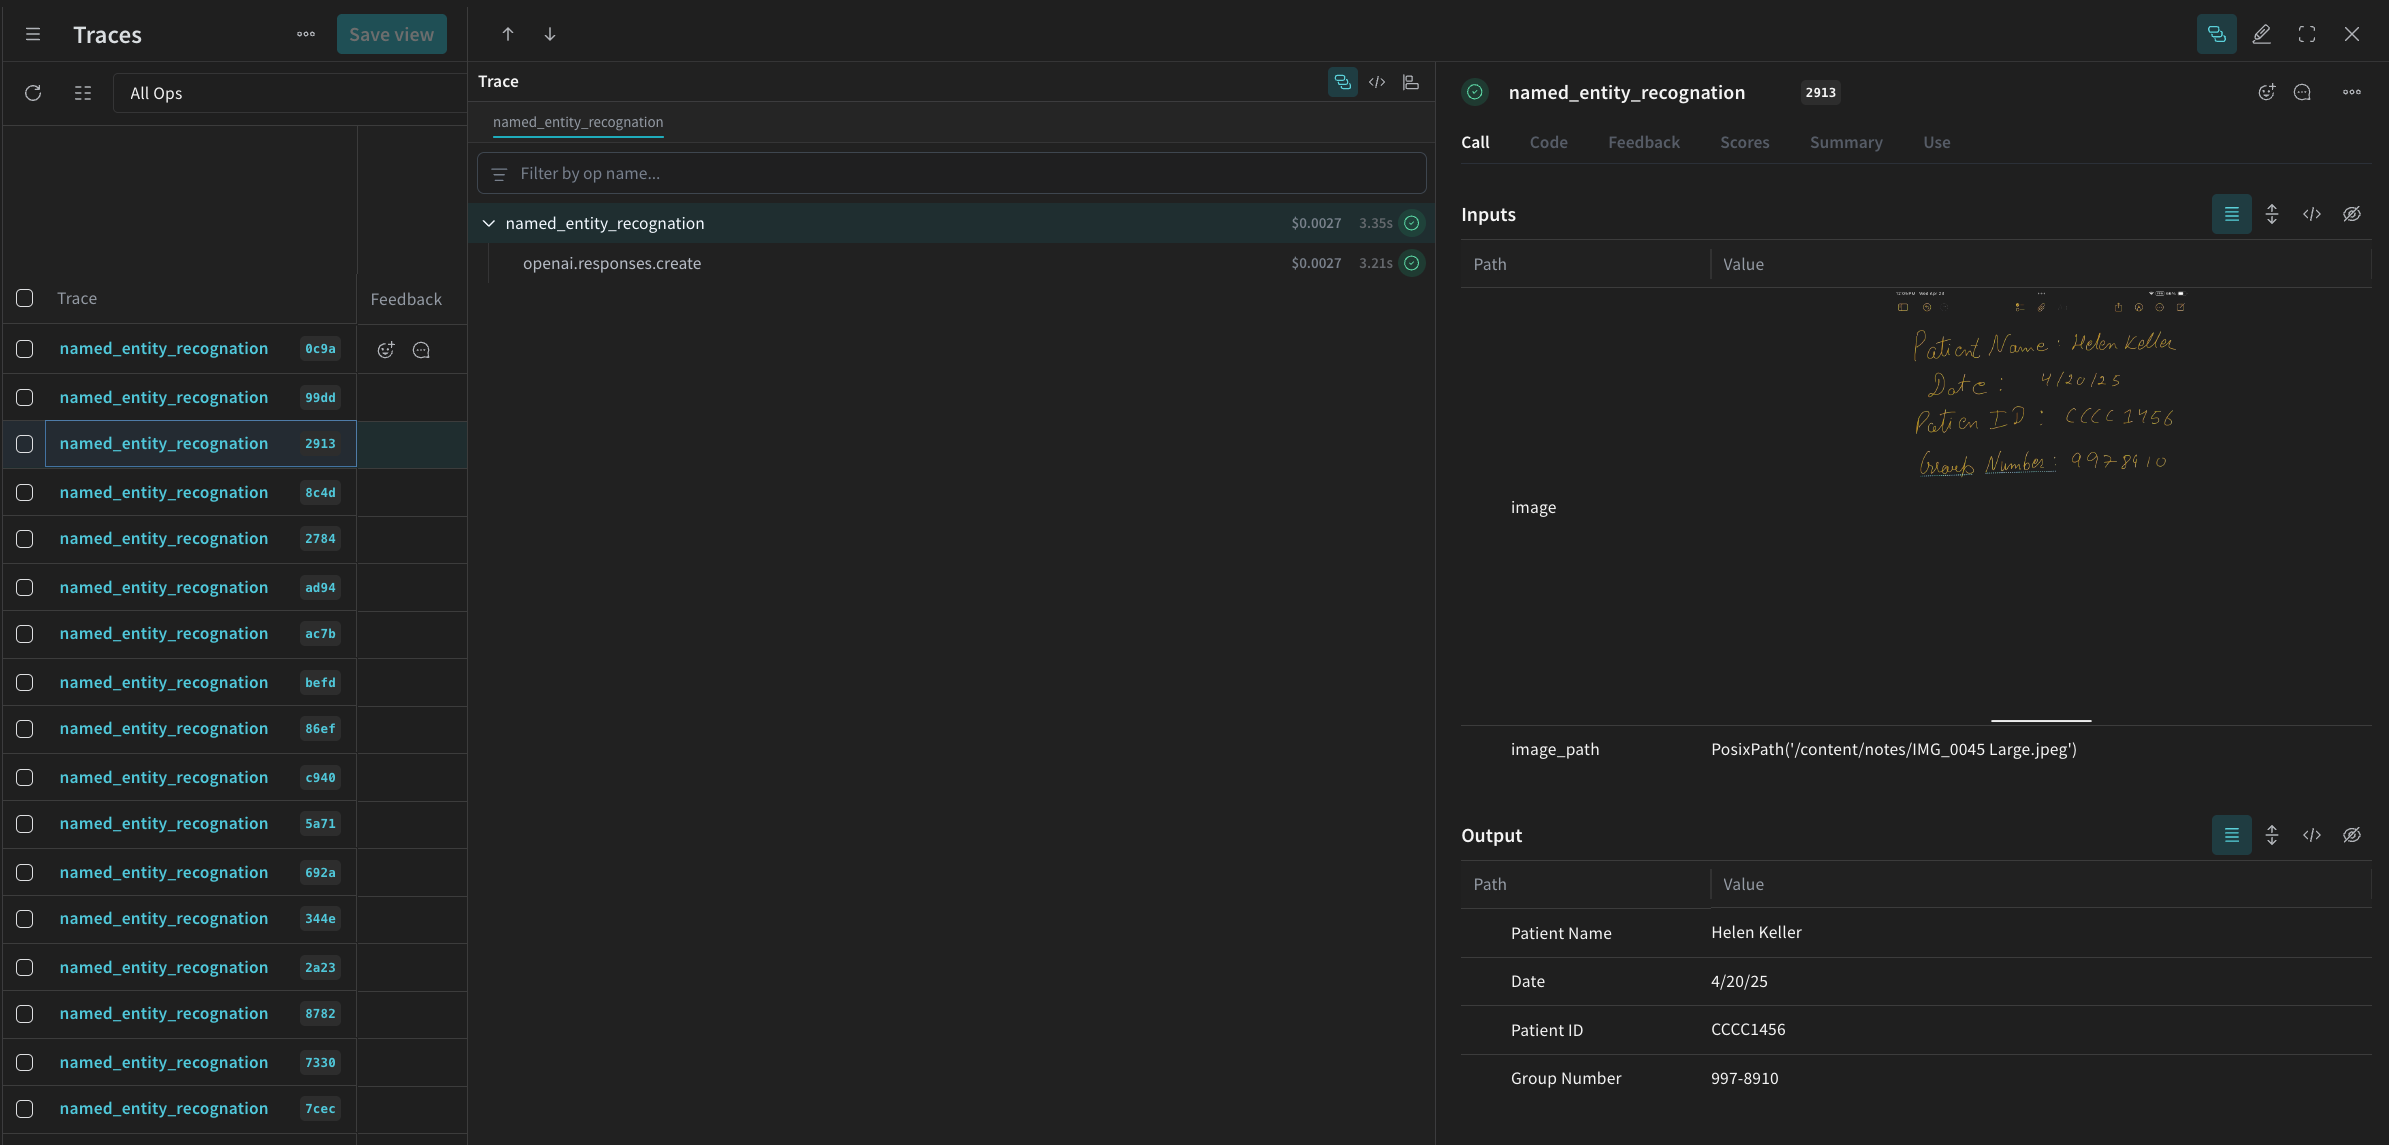

# 4. Evaluating Our Pipeline

Now that we have successfully created a pipeline to perform NER using our VLM, let's evaluate it and find out how well this performs.

In this section, we will create two evaluators for our pipeline:
1. Programtic Evalautor
2. LLM as a Judge Evaluator

## Programatic Evaluator

Let's introduce our first scorer for our pipeline `check_for_missing_fields_programatically`. This function will take the model output, i.e., the output of our `named_entity_recognition` function, and identify which `keys` are missing or emtpy in our results.

This check is great for identifying samples where our model missed capturing any fields.

In [11]:
#adding weave.op() to track execution of the scorer
@weave.op()
def check_for_missing_fields_programatically(model_output):
    # Required keys for every entry
    required_fields = {"Patient Name", "Date", "Patient ID", "Group Number"}

    for key in required_fields:
        if key not in model_output or model_output[key] is None or str(model_output[key]).strip() == "":
            return False # This entry has a missing or empty field

    return True  # All required fields are present and non-empty

## LLM as a Judge Evaluator

In this evaluation, both the image data and the model's output are provided to ensure the assessment reflects actual NER performance, with the image content explicitly referenced, not just the model output.

This scorer results in a *boolean* result for correct execution. If the result is *False* then we also get a reason for what errors caused that.

In [12]:
eval_prompt = """
You are an OCR validation system. Your role is to assess whether the structured text extracted from an image accurately reflects the information in that image.
Only validate the structured text and use the image as your source of truth.

Expected input text format:
{"Patient Name": "First Last", "Date": "04/23/25", "Patient ID": "131313JJH", "Group Number": "35453453"}

Evaluation criteria:
- All four fields must be present.
- No field should be empty or contain placeholder/malformed values.
- The "Date" should be in MM/DD/YY format (e.g., "04/07/25") (zero padding the date is allowed)

Scoring:
- Return: {"Correct": true, "Reason": ""} if **all fields** match the information in the image and formatting is correct.
- Return: {"Correct": false, "Reason": "EXPLANATION"} if **any** field is missing, empty, incorrect, or mismatched.

Output requirements:
- Respond with a valid JSON object only.
- "Correct" must be a JSON boolean: true or false (not a string or number).
- "Reason" must be a short, specific string indicating all the problem — e.g., "Patient Name mismatch", "Date not zero-padded", or "Missing Group Number".
- Do not return any additional explanation or formatting.

Your response must be exactly one of the following:
{"Correct": true, "Reason": null}
OR
{"Correct": false, "Reason": "EXPLANATION_HERE"}
"""

For this LLM-as-a-judge evaluator we will use OpenAI's `gpt-4o` since it offers the same VLM capabilities. You can use any VLM for this task.

In [13]:
#adding weave.op() to track execution of the scorer
@weave.op()
def check_for_missing_fields_with_llm(model_output, image):
  base64_image = encode_image(image)
  client = OpenAI()
  response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "developer",
      "content": [
        {
          "text": eval_prompt,
          "type": "text"
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        },
        {
          "type": "text",
          "text": str(model_output)
        }
      ]
    },
  ],
  response_format={
    "type": "json_object"
  },
  )
  response = json.loads(response.choices[0].message.content)
  return response

# 5. Running the Evaluation

We define an evaluation call that will automatically loop over the `dataset` passed and log the results together in our Weave UI.

Now let's kick off our evaluation, which will apply our scorers to every output from our pipeline and allow us to view the results.

In [14]:
evaluation = weave.Evaluation(
   dataset=dataset, scorers=[check_for_missing_fields_with_llm, check_for_missing_fields_programatically], name="Evaluate_4.1_NER")

print(await (evaluation.evaluate(named_entity_recognation)) )

🍩 https://wandb.ai/wandb-smle/vlm-handwritten-ner/r/call/0196b0a8-a8a6-7333-9b7d-67a6c161d4dc
Processed: IMG_0050 Large.jpeg
Processed: IMG_0047 Large.jpeg
Processed: IMG_0045 Large.jpeg
Processed: IMG_0044 Large.jpeg
Processed: IMG_0046 Large.jpeg
Processed: IMG_0051 Large.jpeg
Processed: IMG_0054 Large.jpeg
Processed: IMG_0052 Large.jpeg
Processed: IMG_0053 Large.jpeg
Processed: IMG_0049 Large.jpeg


Evaluated 1 of 10 examples

Evaluated 2 of 10 examples

Evaluated 3 of 10 examples

Evaluated 4 of 10 examples

Evaluated 5 of 10 examples

Evaluated 6 of 10 examples

Evaluated 7 of 10 examples

Evaluated 8 of 10 examples

Evaluated 9 of 10 examples

Evaluated 10 of 10 examples

Evaluation summary
{
    'check_for_missing_fields_with_llm': {'Correct': {'true_count': 2, 'true_fraction': 0.2}},
    'check_for_missing_fields_programatically': {'true_count': 10, 'true_fraction': 1.0},
    'model_latency': {'mean': 4.444253301620483}
}

{'check_for_missing_fields_with_llm': {'Correct': {'true_count': 2, 'true_fraction': 0.2}}, 'check_for_missing_fields_programatically': {'true_count': 10, 'true_fraction': 1.0}, 'model_latency': {'mean': 4.444253301620483}}


## Conclusion

By following the evaluation link above, you can view the results and compare several iterations of your OCR pipeline across models, prompts, and datasets of your choice. The Weave UI will automatically create a visualization like the one below for your team.   

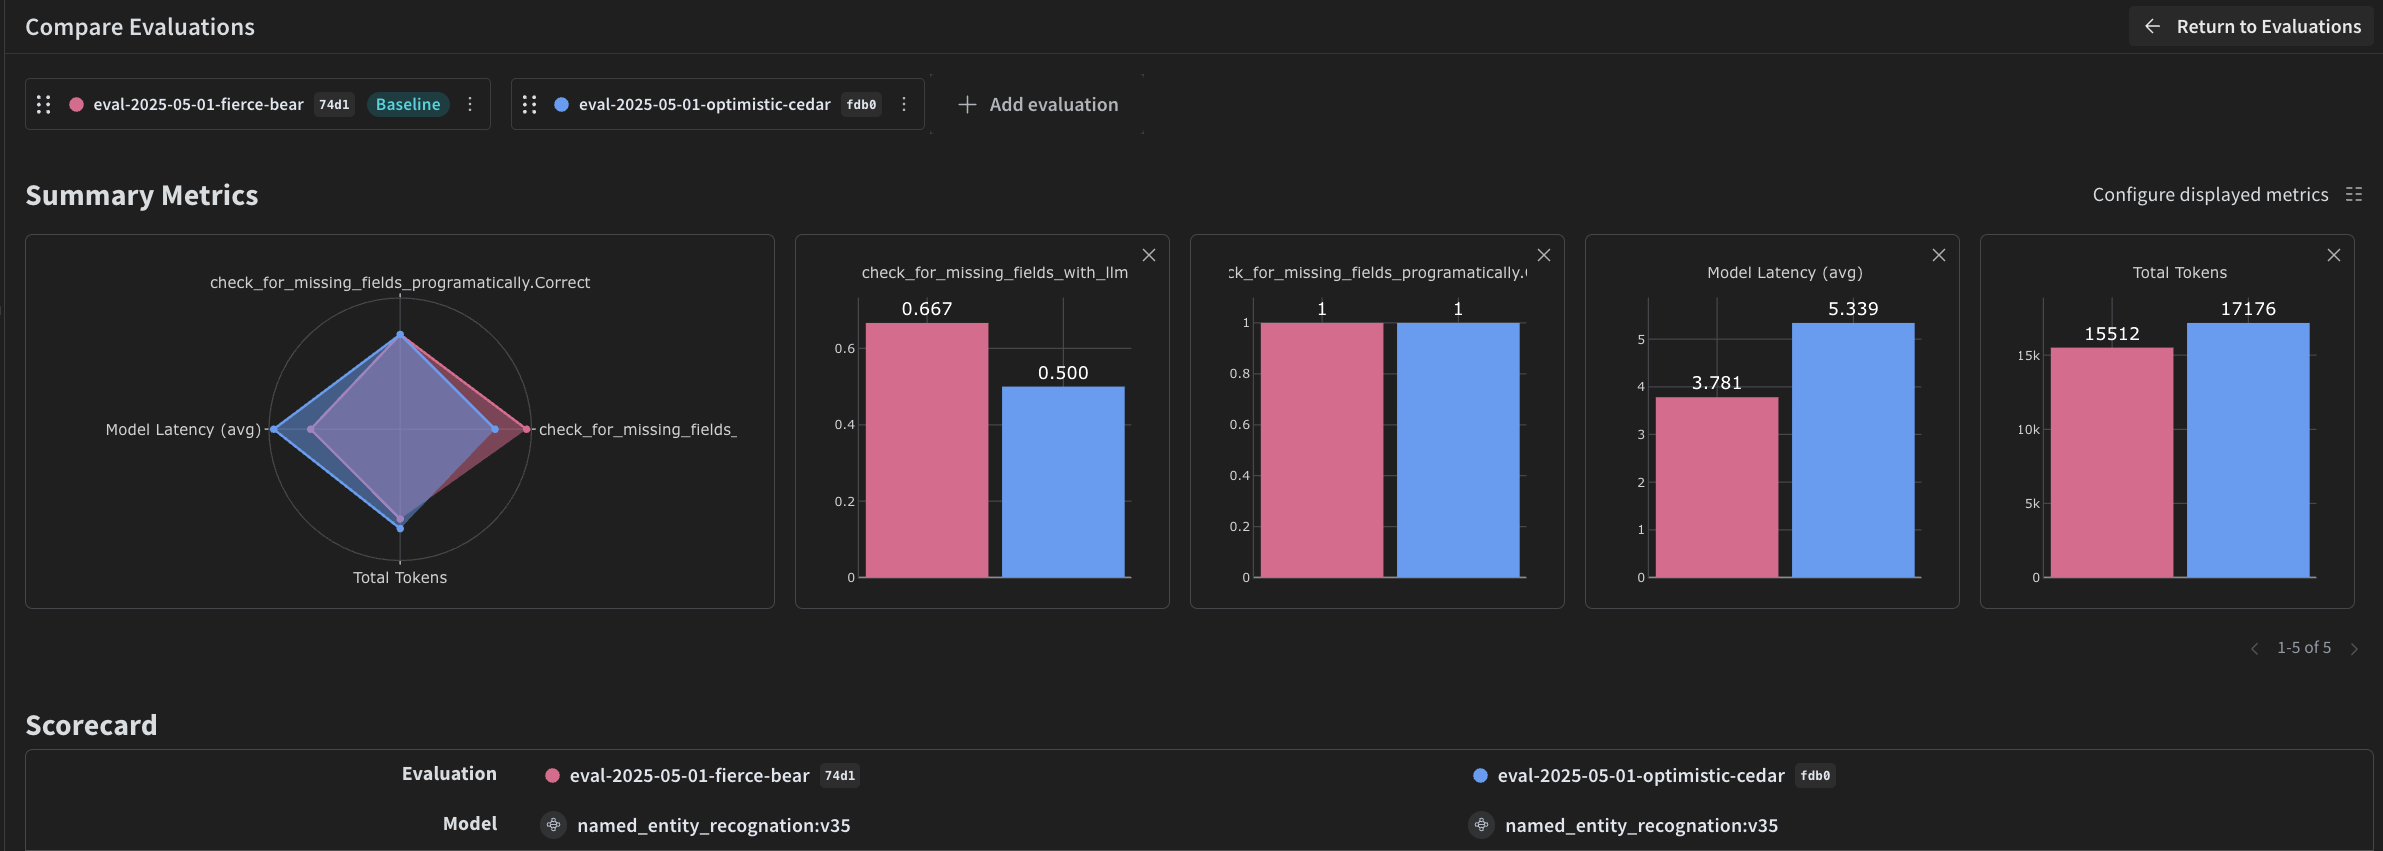

## Conclusion & Next Steps
We've walked through creating, tracking, and evaluating a VLM-based OCR pipeline using Weave and OpenAI. Future improvements could include fine-tuning prompts with human feedback, expanding dataset diversity, or integrating multimodal scoring strategies.